In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# replace with folder for model.py
%cd "/content/drive/MyDrive/Colab Notebooks" 

/content
/content/drive/MyDrive/Colab Notebooks


In [3]:
!pip install torch torchvision timm segmentation-models-pytorch matplotlib numpy
!pip install timm


import os
import torch
import random
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision.transforms.functional import to_pil_image
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2
import segmentation_models_pytorch as smp
from model import model_builder


seed = 3

torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
random.seed(seed)
np.random.seed(seed)
torch.backends.cudnn.benchmark = False
os.environ['PYTHONHASHSEED'] = str(seed)


In [4]:
class SandBoilDataset(Dataset):
    def __init__(self, rootpath, transform=None):
        image_dir = os.path.join(rootpath, 'images')
        mask_dir = os.path.join(rootpath, 'masks')
        self.imgs = []
        self.segs = []

        for filename in os.listdir(image_dir):
            if filename.endswith(".png"):
                image = Image.open(os.path.join(image_dir, filename)).convert('RGB')
                seg = Image.open(os.path.join(mask_dir, filename[:-4] + "_mask.png")).convert('L')

                self.imgs.append(image)
                self.segs.append(seg)
            if filename.endswith(".jpg"):
                image = Image.open(os.path.join(image_dir, filename)).convert('RGB')
                seg = Image.open(os.path.join(mask_dir, filename[:-4] + ".png")).convert('L')

                self.imgs.append(image)
                self.segs.append(seg)

        self.transform = transform

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        image = np.array(self.imgs[idx])
        mask = np.array(self.segs[idx]) / 255.0  # Normalize mask to [0,1]

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented["image"]
            mask = augmented["mask"].unsqueeze(0)  # Add channel dimension

        return image, mask



In [5]:
import torchvision.transforms as transforms

# Define the mean and std used in normalization
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

# Function to denormalize image
def denormalize(tensor, mean, std):
    mean = torch.tensor(mean).view(3, 1, 1)  # Reshape for broadcasting
    std = torch.tensor(std).view(3, 1, 1)
    return tensor * std + mean

# Modify visualization function to apply denormalization
def visualize_dataset(dataset, num_samples=5):
    indices = random.sample(range(len(dataset)), num_samples)

    plt.figure(figsize=(15, num_samples * 3))

    for i, idx in enumerate(indices):
        image, mask = dataset[idx]

        # **Denormalize image if needed**
        if isinstance(image, torch.Tensor):
            image = denormalize(image, mean, std)  # Apply denormalization
            image = to_pil_image(image.clamp(0, 1))  # Convert back to PIL image

        mask = mask.squeeze(0).numpy()  # Convert mask to 2D numpy array

        plt.subplot(num_samples, 2, 2 * i + 1)
        plt.imshow(image)
        plt.axis('off')
        plt.title(f"Image {idx}")

        plt.subplot(num_samples, 2, 2 * i + 2)
        plt.imshow(mask, cmap="gray")
        plt.axis('off')
        plt.title(f"Mask {idx}")

    plt.tight_layout()
    plt.show()

# visualize_dataset(val_dataset, num_samples=5)

In [6]:
image_dir = "/content/drive/MyDrive/Synthetic Sand boil Dataset/Synthetic Sandboil Dataset/Real_test_images/images"
mask_dir = "/content/drive/MyDrive/Synthetic Sand boil Dataset/Synthetic Sandboil Dataset/Real_test_images/masks"
filename = "img_(1).jpg"
image = Image.open(os.path.join(image_dir, filename)).convert('RGB')


seg = Image.open(os.path.join(mask_dir, filename[:-4] + ".png")).convert('L')

print(image.size)
print(seg.size)

(512, 512)
(512, 512)


In [7]:
image_dir = "/content/drive/MyDrive/Synthetic Sand boil Dataset/Synthetic Sandboil Dataset/Synthetic_training_images/images"
mask_dir = "/content/drive/MyDrive/Synthetic Sand boil Dataset/Synthetic Sandboil Dataset/Synthetic_training_images/masks"
filename = "generated_sandboil_1.png"
image = Image.open(os.path.join(image_dir, filename)).convert('RGB')


seg = Image.open(os.path.join(mask_dir, filename[:-4] + "_mask.png")).convert('L')

print(image.size)
print(seg.size)

(512, 512)
(512, 512)


In [8]:
# Define image size and batch size
IMG_SIZE = 224
BATCH_SIZE = 8

# Data transformations
train_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),  # Normalize images
    ToTensorV2()], seed=seed
)

val_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

# Load datasets
trainpath = "/content/drive/MyDrive/Synthetic Sand boil Dataset/Synthetic Sandboil Dataset/Synthetic_training_images"
valpath = "/content/drive/MyDrive/Synthetic Sand boil Dataset/Synthetic Sandboil Dataset/Real_test_images"
testpath = "/content/drive/MyDrive/Synthetic Sand boil Dataset/Synthetic Sandboil Dataset/Real_test_images"
train_dataset = SandBoilDataset(rootpath=trainpath, transform=train_transform)
full_eval_dataset = SandBoilDataset(rootpath=valpath, transform=val_transform)
val_dataset = Subset(full_eval_dataset, range(10))
test_dataset = Subset(full_eval_dataset, range(10, 50))

# Load data into PyTorch DataLoader
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [9]:
len(SandBoilDataset(rootpath=valpath, transform=val_transform))


51

In [10]:


# model can be "CNN", "Swin U-Net", or "EfficientNet"

model, device = model_builder("EfficientNet")



/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [11]:
import segmentation_models_pytorch as smp

class CombinedLoss(nn.Module):
    def __init__(self, alpha=0.5):
        super(CombinedLoss, self).__init__()
        self.dice_loss = smp.losses.DiceLoss(mode="binary")
        self.bce_loss = nn.BCEWithLogitsLoss()
        self.alpha = alpha

    def forward(self, preds, targets):
        dice = self.dice_loss(preds, targets)
        bce = self.bce_loss(preds, targets)
        return self.alpha * dice + (1 - self.alpha) * bce

# loss_fn = nn.BCEWithLogitsLoss()
loss_fn = CombinedLoss()
# 5e-5, 1e-(-3)
# 1e-5, 1e-3
optimizer = optim.AdamW(model.parameters(), lr=1e-5, weight_decay=1e-2)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3)



In [12]:
def dice_score(y_true, y_pred, threshold=0.5):
    y_pred = (y_pred > threshold).float()
    intersection = (y_true * y_pred).sum()
    return (2. * intersection) / (y_true.sum() + y_pred.sum() + 1e-6)

def train_one_epoch(model, loader, optimizer, loss_fn, device):
    model.train()

    train_loss = 0.0
    for images, masks in loader:

        images, masks = images.to(device), masks.to(device)
        if masks.ndim == 3:

            masks = masks.unsqueeze(1)

        optimizer.zero_grad()

        outputs = model(images)
        loss = loss_fn(outputs, masks)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
    return train_loss / len(loader)

def validate_one_epoch(model, loader, loss_fn, device):
    model.eval()
    val_loss = 0.0
    dice_scores = []
    with torch.no_grad():
        for images, masks in loader:
            images, masks = images.to(device), masks.to(device)

            if masks.ndim == 3:

                masks = masks.unsqueeze(1)

            outputs = model(images)
            loss = loss_fn(outputs, masks)
            val_loss += loss.item()

            preds = torch.sigmoid(outputs)
            for i in range(len(masks)):
                dice = dice_score(masks[i], preds[i])
                dice_scores.append(dice.item())

    avg_dice = np.mean(dice_scores) if len(dice_scores) > 0 else 0.0
    return val_loss / max(1, len(loader)), avg_dice


In [13]:
# Check one sample
image, mask = train_dataset[0]
print("Image Shape:", image.shape)  # Should be (3, 224, 224)
print("Mask Shape:", mask.shape)    # Should be (1, 224, 224)

# Check DataLoader shapes
for img, msk in train_loader:
    print("Batch Image Shape:", img.shape)  # Should be (batch_size, 3, 224, 224)
    print("Batch Mask Shape:", msk.shape)   # Should be (batch_size, 1, 224, 224)
    break


Image Shape: torch.Size([3, 224, 224])
Mask Shape: torch.Size([1, 224, 224])
Batch Image Shape: torch.Size([8, 3, 224, 224])
Batch Mask Shape: torch.Size([8, 1, 224, 224])


In [14]:
NUM_EPOCHS = 25
best_val_loss = float("inf")
best_val_dice = float(-1)

for epoch in range(NUM_EPOCHS):
    train_loss = train_one_epoch(model, train_loader, optimizer, loss_fn, device)
    val_loss, val_dice = validate_one_epoch(model, val_loader, loss_fn, device)

    # scheduler.step(val_loss)

    print(f"Epoch {epoch+1}/{NUM_EPOCHS} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Dice Score: {val_dice:.4f}")

    if val_dice > best_val_dice:
    # if val_loss < best_val_loss:
        # best_val_loss = val_loss
        best_val_dice = val_dice
        torch.save(model.state_dict(), "best_swin_unet_sandboil.pth")
        print("🔥 Best Model Saved!")

print("✅ Training complete!")

# 16, 0.6275
# 16, new learning rate, 0.6410
# 16, new weights, 0.6257
# 16, 1e-5, 1877 loss, 6970 dice, loss focus, 5673 test
# 16, 1e-5, 2223 loss, 7003 dice, dice focus, 5933 test






Epoch 1/25 | Train Loss: 0.7026 | Val Loss: 0.6755 | Val Dice Score: 0.2412
🔥 Best Model Saved!
Epoch 2/25 | Train Loss: 0.6443 | Val Loss: 0.6129 | Val Dice Score: 0.3210
🔥 Best Model Saved!
Epoch 3/25 | Train Loss: 0.5643 | Val Loss: 0.5573 | Val Dice Score: 0.3632
🔥 Best Model Saved!
Epoch 4/25 | Train Loss: 0.4941 | Val Loss: 0.5189 | Val Dice Score: 0.4222
🔥 Best Model Saved!
Epoch 5/25 | Train Loss: 0.4447 | Val Loss: 0.4903 | Val Dice Score: 0.4548
🔥 Best Model Saved!
Epoch 6/25 | Train Loss: 0.4075 | Val Loss: 0.4774 | Val Dice Score: 0.5115
🔥 Best Model Saved!
Epoch 7/25 | Train Loss: 0.3718 | Val Loss: 0.4393 | Val Dice Score: 0.5449
🔥 Best Model Saved!
Epoch 8/25 | Train Loss: 0.3488 | Val Loss: 0.4317 | Val Dice Score: 0.5579
🔥 Best Model Saved!
Epoch 9/25 | Train Loss: 0.3267 | Val Loss: 0.3907 | Val Dice Score: 0.5771
🔥 Best Model Saved!
Epoch 10/25 | Train Loss: 0.3046 | Val Loss: 0.3790 | Val Dice Score: 0.5871
🔥 Best Model Saved!
Epoch 11/25 | Train Loss: 0.2882 | Val 

KeyboardInterrupt: 

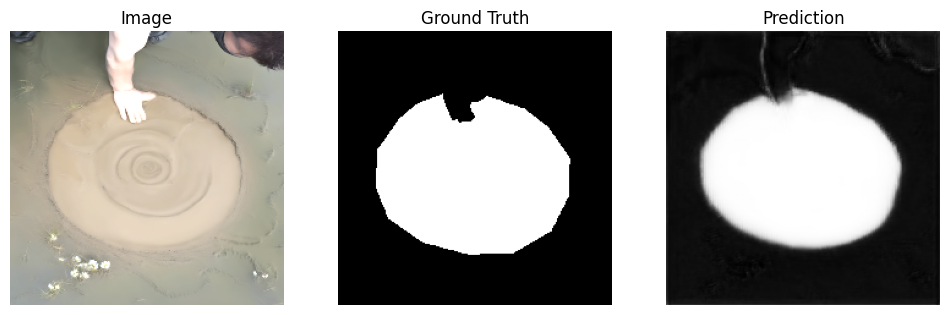

In [15]:
def show_prediction(idx):
    """
    Shows an image, ground truth mask, and predicted mask from the validation dataset.
    """
    model.eval()
    image, mask = train_dataset[idx]
    image_tensor = image.to(device).unsqueeze(0)  # Add batch dimension

    with torch.no_grad():
        pred_mask = model(image_tensor)

    pred_mask = torch.sigmoid(pred_mask).squeeze().cpu().numpy()

    # Plot the images
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(to_pil_image(denormalize(image.cpu(), mean, std)))
    plt.axis("off")
    plt.title("Image")

    plt.subplot(1, 3, 2)
    plt.imshow(mask.squeeze().cpu().numpy(), cmap="gray")
    plt.axis("off")
    plt.title("Ground Truth")

    plt.subplot(1, 3, 3)
    plt.imshow(pred_mask, cmap="gray")
    plt.axis("off")
    plt.title("Prediction")

    plt.show()

# Example usage
show_prediction(3)


In [16]:
def test(model, loader, device):
    model.eval()
    test_loss = 0.0
    dice_scores = []
    with torch.no_grad():
        for images, masks in loader:
            images, masks = images.to(device), masks.to(device)

            if masks.ndim == 3:

                masks = masks.unsqueeze(1)

            outputs = model(images)



            preds = torch.sigmoid(outputs)
            for i in range(len(masks)):
                dice = dice_score(masks[i], preds[i])
                dice_scores.append(dice.item())

    avg_dice = np.mean(dice_scores) if len(dice_scores) > 0 else 0.0
    return avg_dice


test_dice = test(model, test_loader, device)

print(f"Test Dice: {test_dice:.4f}")

Test Dice: 0.6185
